## Set up environment

In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

  Using cached https://files.pythonhosted.org/packages/4c/1a/0d79814736cfecc825ab8094b39648cc9c46af7af1bae839928acb73b4dd/tensorflow-2.2.0-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d6/84/759f5dd23fec8ba71952d97bcc7e2c9d7d63bdc582421f3cd4be845f0c98/gast-0.3.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1d/74/0a6fcb206dcc72a6da9a62dd81784bfdbff5fedb099982861dc2219014fb/tensorboard-2.2.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a4/f5/926ae53d6a226ec0fda5208e0e581cffed895ccc89e36ba76a8e60895b78/tensorflow_estimator-2.2.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3f/c0/abde58b837e066bca19a3f7332d9d0493521d7dd6b48248451a9e3fe2214/h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: tf-models-official 2.5.0 has requirement tensorflow>=2.5.0, but you'll have tensorflow 2.2.0 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstal

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Using cached https://files.pythonhosted.org/packages/aa/fd/993aa1333eb54d9f000863fe8ec61e41d12eb833dea51484c76c038718b5/tensorflow-2.5.0-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/44/f5/7feea02a3fb54d5db827ac4b822a7ba8933826b36de21880518250b8733a/tensorboard-2.5.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/78/b27f73e923becc6e79e18fe112cf75e3200d1ee35b0dba8fa46181bce56c/tensorflow_estimator-2.5.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9d/74/9eae2bedd8201ab464308f42c601a12d79727a1c87f0c867fdefb212c6cf/h5py-3.1.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b6/48/583c032b79ae5b3daa02225a675aeb673e58d2cb698e78510feceb11958c/gast-0.4.0-py3-none-any.whl
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1658497 sha256=8ed172839baa39be4eec45fd1500e67b0c42b264

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%bash
ls -l 'drive/MyDrive/Colab Notebooks/car_train'

total 40291
-rw------- 1 root root 20497793 Jul 12 09:46 car_race1.gif
-rw------- 1 root root  1892029 Jul 12 09:50 car_race1.mp4
-rw------- 1 root root   140122 Jul 11 20:18 cart_10.jpg
-rw------- 1 root root   127480 Jul 11 19:24 cart_11.jpg
-rw------- 1 root root   137639 Jul 11 19:32 cart_12.jpg
-rw------- 1 root root   138096 Jul 11 19:35 cart_13.jpg
-rw------- 1 root root   134105 Jul 11 19:38 cart_14.jpg
-rw------- 1 root root   141009 Jul 11 19:44 cart_15.jpg
-rw------- 1 root root   140538 Jul 11 19:50 cart_16.jpg
-rw------- 1 root root   141956 Jul 11 20:03 cart_17.jpg
-rw------- 1 root root   140446 Jul 11 20:04 cart_18.jpg
-rw------- 1 root root   140850 Jul 11 20:05 cart_19.jpg
-rw------- 1 root root   134760 Jul 11 20:14 cart_1.jpg
-rw------- 1 root root   140411 Jul 11 20:06 cart_20.jpg
-rw------- 1 root root   139336 Jul 11 20:07 cart_21.jpg
-rw------- 1 root root   136427 Jul 11 20:14 cart_2.jpg
-rw------- 1 root root   136483 Jul 11 20:15 cart_3.jpg
-rw------- 1 root 

# Utilities

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
#  print("image_np_with_annotations=",image_np_with_annotations)
#  print("boxes=",boxes)
#  print("classes=",classes)
#  print("scores=",scores)
#  print("category_index=",category_index)
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.4,
#      min_score_thresh=0,
#      max_boxes_to_draw=100)
      max_boxes_to_draw=num_classes)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Car data

Load training images and display them.  

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


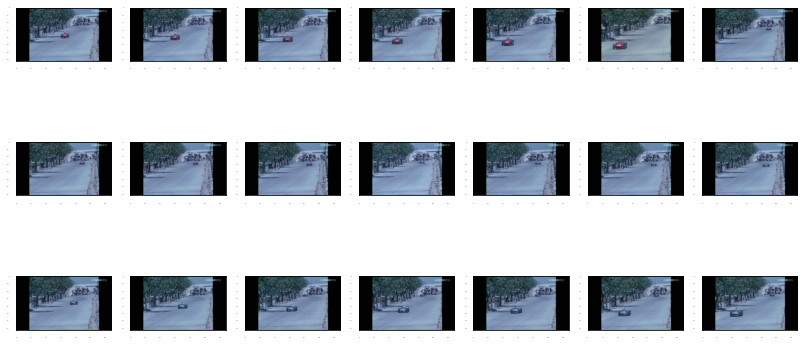

In [ ]:
# Load images and visualize
train_image_dir = 'drive/MyDrive/Colab Notebooks/car_train'
train_images_np = []

for i in range(1, 22):
  image_path = os.path.join(train_image_dir, 'cart_' + str(i) + '.jpg')
  print(i)
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(3, 7, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Label images with bounding boxes

Label the cars by drawing a box around the car in each image; click `next image` to go to the next image and `submit` when there are no more images.



In [ ]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)
print(gt_boxes)

<IPython.core.display.Javascript object>

[]


To save having to label each image, the following cell can be executed instead:

In [ ]:
gt_boxes=[np.array([[0.445     , 0.46328125, 0.58166667, 0.5546875 ],
        [0.50666667, 0.490625  , 0.53666667, 0.52421875],
        [0.35      , 0.36875   , 0.49      , 0.39765625],
        [0.25166667, 0.7328125 , 0.34333333, 0.753125  ]]),
 np.array([[0.47166667, 0.4203125 , 0.61666667, 0.5234375 ],
        [0.53833333, 0.44765625, 0.57      , 0.48203125],
        [0.35      , 0.3765625 , 0.48166667, 0.409375  ],
        [0.24166667, 0.740625  , 0.33333333, 0.7625    ]]),
 np.array([[0.5       , 0.38984375, 0.66166667, 0.50078125],
        [0.575     , 0.421875  , 0.60833333, 0.459375  ],
        [0.36833333, 0.38984375, 0.5       , 0.41171875],
        [0.25333333, 0.75234375, 0.33666667, 0.76953125]]),
 np.array([[0.51833333, 0.340625  , 0.695     , 0.45859375],
        [0.60666667, 0.37421875, 0.64      , 0.4125    ],
        [0.34666667, 0.3875    , 0.47833333, 0.4140625 ],
        [0.245     , 0.746875  , 0.32833333, 0.76875   ]]),
 np.array([[0.53666667, 0.29453125, 0.73      , 0.42734375],
        [0.625     , 0.33125   , 0.66666667, 0.37578125],
        [0.325     , 0.4       , 0.46666667, 0.428125  ],
        [0.22666667, 0.76328125, 0.315     , 0.78359375]]),
 np.array([[0.58166667, 0.2609375 , 0.79166667, 0.409375  ],
        [0.68666667, 0.2953125 , 0.72833333, 0.34296875],
        [0.315     , 0.459375  , 0.45666667, 0.48203125],
        [0.22666667, 0.81953125, 0.30666667, 0.83984375]]),
 np.array([[0.35      , 0.66640625, 0.43333333, 0.72109375],
        [0.385     , 0.68203125, 0.40833333, 0.70390625],
        [0.38666667, 0.346875  , 0.51666667, 0.371875  ],
        [0.28333333, 0.709375  , 0.36166667, 0.73046875]]),
 np.array([[0.35666667, 0.66171875, 0.44      , 0.71796875],
        [0.39      , 0.67890625, 0.41333333, 0.7       ],
        [0.38166667, 0.340625  , 0.51166667, 0.36953125],
        [0.28333333, 0.70625   , 0.37      , 0.725     ]]),
 np.array([[0.36      , 0.6546875 , 0.44333333, 0.71328125],
        [0.39666667, 0.6703125 , 0.41833333, 0.69453125],
        [0.39      , 0.3375    , 0.52      , 0.3640625 ],
        [0.285     , 0.7       , 0.37166667, 0.72109375]]),
 np.array([[0.37333333, 0.6375    , 0.46666667, 0.70234375],
        [0.41333333, 0.6546875 , 0.435     , 0.68046875],
        [0.39      , 0.334375  , 0.525     , 0.35859375],
        [0.29      , 0.69609375, 0.38      , 0.7171875 ]]),
 np.array([[0.335     , 0.628125  , 0.42      , 0.6828125 ],
        [0.36666667, 0.64375   , 0.39      , 0.66953125],
        [0.36166667, 0.33046875, 0.51      , 0.35703125],
        [0.27833333, 0.69140625, 0.36166667, 0.7125    ]]),
 np.array([[0.355     , 0.64765625, 0.44      , 0.70625   ],
        [0.38666667, 0.6625    , 0.40666667, 0.68984375],
        [0.36666667, 0.33515625, 0.51666667, 0.36640625],
        [0.29833333, 0.6953125 , 0.375     , 0.7109375 ]]),
 np.array([[0.375     , 0.65546875, 0.46666667, 0.7140625 ],
        [0.40666667, 0.66953125, 0.43333333, 0.7015625 ],
        [0.38      , 0.34140625, 0.53333333, 0.3703125 ],
        [0.28666667, 0.703125  , 0.38833333, 0.7234375 ]]),
 np.array([[0.38833333, 0.63515625, 0.48166667, 0.7046875 ],
        [0.42      , 0.6515625 , 0.445     , 0.68203125],
        [0.36833333, 0.334375  , 0.52333333, 0.36484375],
        [0.285     , 0.69921875, 0.375     , 0.7203125 ]]),
 np.array([[0.42      , 0.56171875, 0.53666667, 0.6453125 ],
        [0.46666667, 0.58046875, 0.49833333, 0.6171875 ],
        [0.35833333, 0.3578125 , 0.50166667, 0.38203125],
        [0.26833333, 0.71875   , 0.35      , 0.73984375]]),
 np.array([[0.46833333, 0.496875  , 0.61333333, 0.59921875],
        [0.53      , 0.525     , 0.56166667, 0.56015625],
        [0.36166667, 0.39453125, 0.50166667, 0.4203125 ],
        [0.265     , 0.759375  , 0.355     , 0.77734375]]),
 np.array([[0.505     , 0.43046875, 0.66333333, 0.546875  ],
        [0.57166667, 0.4578125 , 0.60333333, 0.496875  ],
        [0.36      , 0.4109375 , 0.495     , 0.4390625 ],
        [0.26      , 0.7734375 , 0.34833333, 0.7921875 ]]),
 np.array([[0.525     , 0.40390625, 0.68833333, 0.52578125],
        [0.595     , 0.43046875, 0.63666667, 0.47578125],
        [0.355     , 0.4171875 , 0.5       , 0.4421875 ],
        [0.265     , 0.78046875, 0.355     , 0.80078125]]),
 np.array([[0.535     , 0.390625  , 0.70166667, 0.51171875],
        [0.605     , 0.41875   , 0.63833333, 0.4609375 ],
        [0.36      , 0.4234375 , 0.50166667, 0.44609375],
        [0.26      , 0.78203125, 0.35166667, 0.80390625]]),
 np.array([[0.56333333, 0.31328125, 0.75      , 0.44375   ],
        [0.64166667, 0.3453125 , 0.68333333, 0.3953125 ],
        [0.35166667, 0.41953125, 0.49833333, 0.446875  ],
        [0.25833333, 0.7828125 , 0.34666667, 0.8046875 ]]),
 np.array([[0.57333333, 0.290625  , 0.75833333, 0.42734375],
        [0.64833333, 0.32421875, 0.69      , 0.37265625],
        [0.34166667, 0.4296875 , 0.49166667, 0.453125  ],
        [0.25      , 0.79140625, 0.33333333, 0.809375  ]])]

In [ ]:
gt_boxes

[array([[0.445     , 0.46328125, 0.58166667, 0.5546875 ],
        [0.50666667, 0.490625  , 0.53666667, 0.52421875],
        [0.35      , 0.36875   , 0.49      , 0.39765625],
        [0.25166667, 0.7328125 , 0.34333333, 0.753125  ]]),
 array([[0.47166667, 0.4203125 , 0.61666667, 0.5234375 ],
        [0.53833333, 0.44765625, 0.57      , 0.48203125],
        [0.35      , 0.3765625 , 0.48166667, 0.409375  ],
        [0.24166667, 0.740625  , 0.33333333, 0.7625    ]]),
 array([[0.5       , 0.38984375, 0.66166667, 0.50078125],
        [0.575     , 0.421875  , 0.60833333, 0.459375  ],
        [0.36833333, 0.38984375, 0.5       , 0.41171875],
        [0.25333333, 0.75234375, 0.33666667, 0.76953125]]),
 array([[0.51833333, 0.340625  , 0.695     , 0.45859375],
        [0.60666667, 0.37421875, 0.64      , 0.4125    ],
        [0.34666667, 0.3875    , 0.47833333, 0.4140625 ],
        [0.245     , 0.746875  , 0.32833333, 0.76875   ]]),
 array([[0.53666667, 0.29453125, 0.73      , 0.42734375],
      

# Prepare data for training

Add the class annotations.

Also convert data to the format required by the training loop below (e.g. convert to tensors, classes converted to one-hot representations, etc.).

In [ ]:
car_class_id = 0
class2_id = 1
class3_id = 2
class4_id = 3
num_classes = 4

category_index = {
    car_class_id: {'id': car_class_id, 'name': 'racing car'},
    class2_id: {'id': class2_id, 'name': 'number'},
    class3_id: {'id': class3_id, 'name': 'person 1'},
    class4_id: {'id': class4_id, 'name': 'person 2'}
}


In [ ]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  z=np.array([0,1,2,3])
#  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
#      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(z, num_classes))
#      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


# Visualise training data with annotations


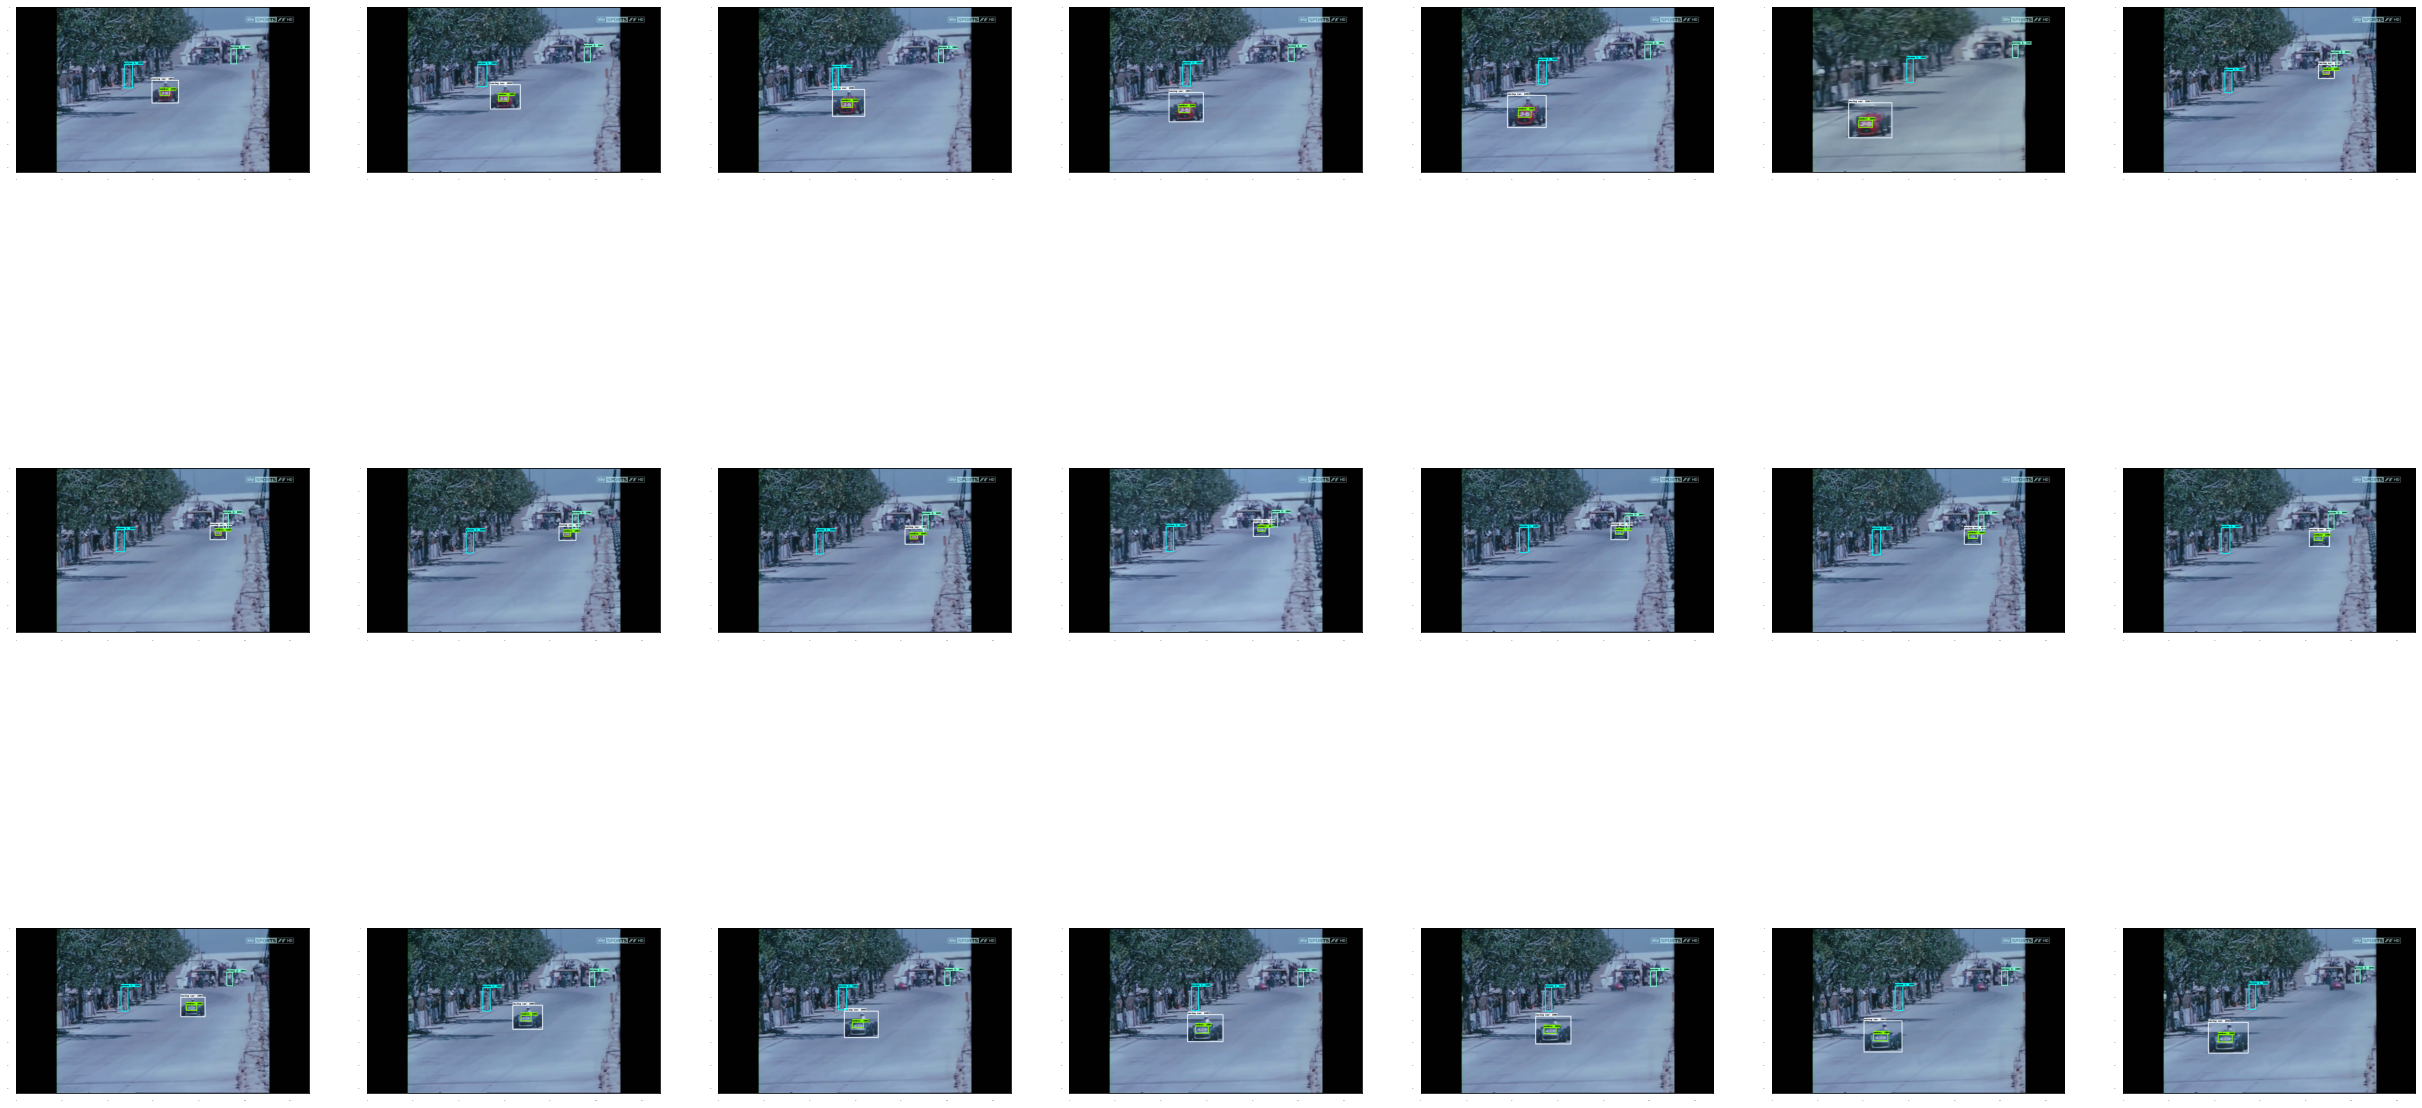

In [ ]:
dummy_scores = np.array([1,1,1,1], dtype=np.float32)  # give boxes a score of 100%
plt.figure(figsize=(43, 24))
for idx in range(21):
  plt.subplot(3, 7, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      [0,1,2,3],
      dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-07-12 17:47:20--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.153.128, 2a00:1450:4013:c16::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.153.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.4’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   187MB/s    in 1.2s    

2021-07-12 17:47:21 (187 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.4’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 4
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field 
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

batch_size = 10  # As there are 10 images     
learning_rate = 0.01
num_batches = 100 # was 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
%xmode Verbose
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')
import os
os.system('say "Training has finished"')

Start fine-tuning!
Exception reporting mode: Verbose
batch 0 of 100, loss=1.3576202
batch 10 of 100, loss=0.4411496
batch 20 of 100, loss=0.28705934
batch 30 of 100, loss=0.23130289
batch 40 of 100, loss=0.17531082
batch 50 of 100, loss=0.15661238
batch 60 of 100, loss=0.15775183
batch 70 of 100, loss=0.1259059
batch 80 of 100, loss=0.1135861
batch 90 of 100, loss=0.11062652
Done fine-tuning!


32512

In [ ]:
%%bash
ls -l 'drive/MyDrive/Colab Notebooks/car_test'

total 9431
-rw------- 1 root root 136366 Jul 11 18:03 car_10.jpg
-rw------- 1 root root 134105 Jul 11 18:04 car_11.jpg
-rw------- 1 root root 134498 Jul 11 18:04 car_12.jpg
-rw------- 1 root root 137434 Jul 11 18:04 car_13.jpg
-rw------- 1 root root 138412 Jul 11 18:04 car_14.jpg
-rw------- 1 root root 137420 Jul 11 18:05 car_15.jpg
-rw------- 1 root root 136733 Jul 11 18:05 car_16.jpg
-rw------- 1 root root 136676 Jul 11 18:05 car_17.jpg
-rw------- 1 root root 137260 Jul 11 18:12 car_18.jpg
-rw------- 1 root root 137857 Jul 11 18:12 car_19.jpg
-rw------- 1 root root 127480 Jul 11 18:02 car_1.jpg
-rw------- 1 root root 140304 Jul 11 18:12 car_20.jpg
-rw------- 1 root root 139971 Jul 11 18:12 car_21.jpg
-rw------- 1 root root 141770 Jul 11 18:13 car_22.jpg
-rw------- 1 root root 141661 Jul 11 18:13 car_23.jpg
-rw------- 1 root root 141182 Jul 11 18:13 car_24.jpg
-rw------- 1 root root 140678 Jul 11 18:14 car_25.jpg
-rw------- 1 root root 140181 Jul 11 18:15 car_26.jpg
-rw------- 1 root 

# Load test images and run inference with new model

In [ ]:
test_image_dir = 'drive/MyDrive/Colab Notebooks/car_test'
test_images_np = []
for i in range(1, 72):
  image_path = os.path.join(test_image_dir, 'car_' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

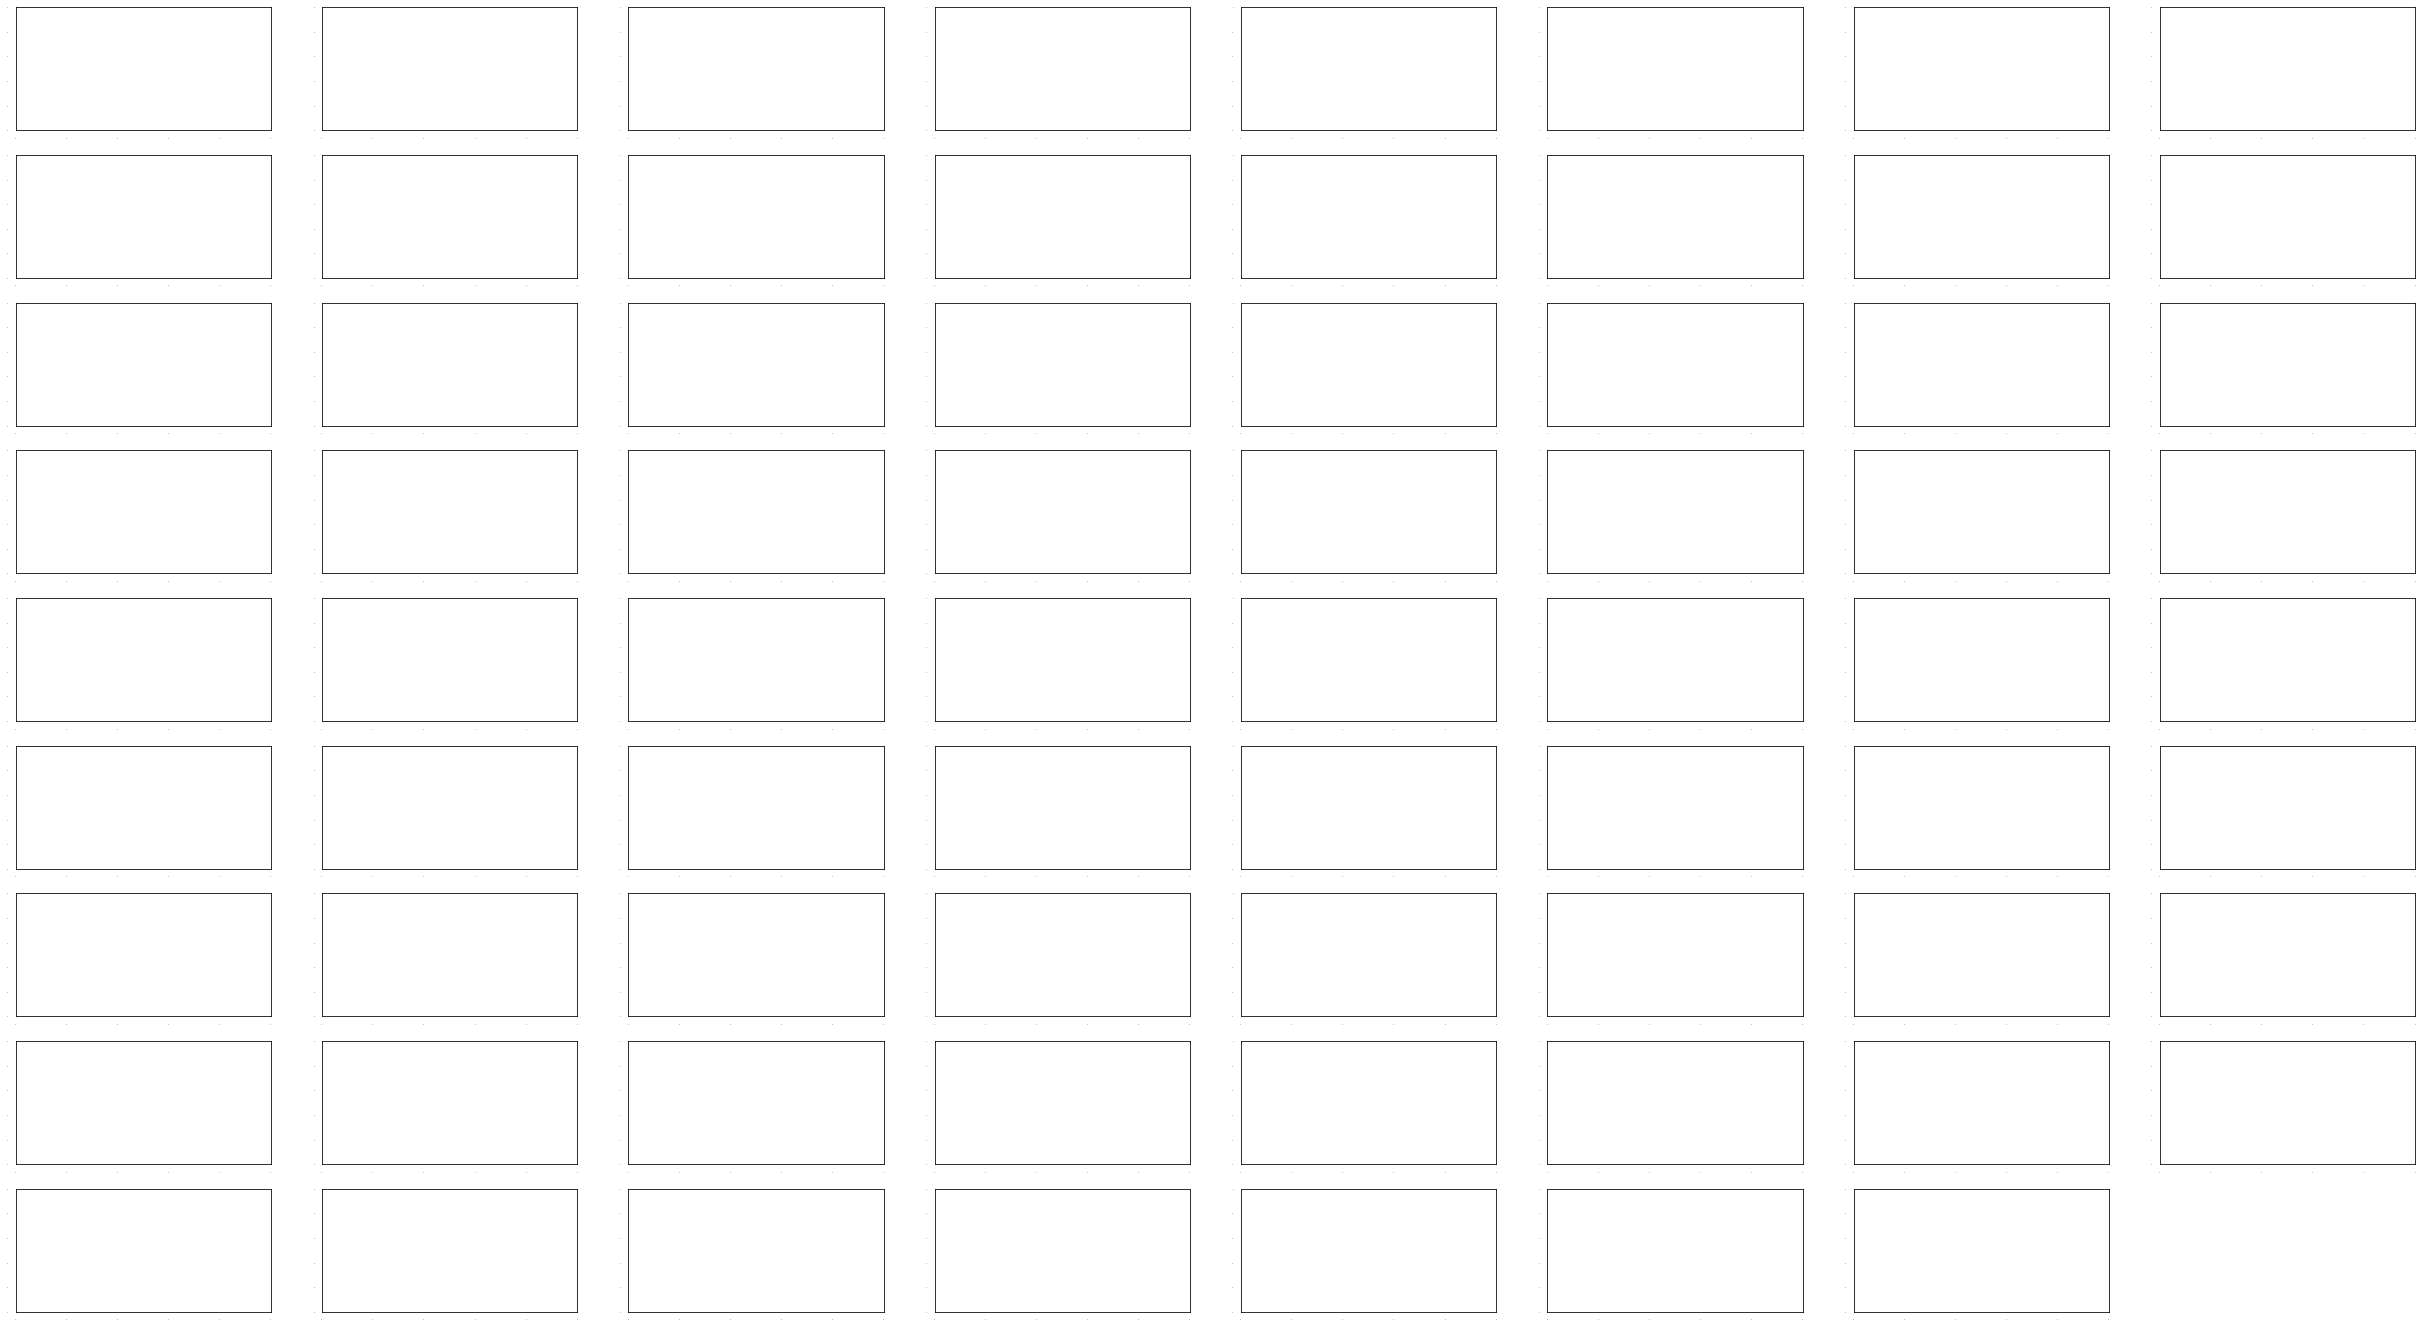

In [ ]:
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

plt.figure(figsize=(43, 24))
for i in range(0,71):
  plt.subplot(9, 8, i+1)
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32),
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

plt.show()

In [ ]:
# Used to display all 100 boxes which are detected by the model.  In order to do this, the following parameters have to be set in the plot_detections function:
# min_score_thresh=0, 
# max_boxes_to_draw=100
# The putput is written to boxes.jpg
plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32),
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="boxes.jpg")

In [ ]:
detections['detection_classes']

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 2., 1., 3., 1.,
        1., 1., 2., 0., 1., 3., 2., 1., 1., 1., 2., 1., 2., 2., 3., 1.,
        2., 1., 1., 0., 2., 2., 2., 1., 2., 1., 2., 2., 1., 2., 2., 1.,
        2., 0., 2., 2., 2., 2., 2., 0., 2., 1., 2., 1., 2., 2., 2., 3.,
        1., 0., 1., 1., 2., 3., 2., 2., 2., 2., 1., 1., 2., 0., 2., 1.,
        2., 1., 1., 2., 2., 2., 2., 2., 2., 1., 1., 0., 2., 2., 2., 2.,
        2., 2., 1., 2.]], dtype=float32)>

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'car_race1.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import moviepy.editor as mp

clip = mp.VideoFileClip("car_race1.gif")
clip.write_videofile("car_race1.mp4")

[MoviePy] >>>> Building video car_race1.mp4
[MoviePy] Writing video car_race1.mp4


 99%|█████████▊| 71/72 [00:02<00:00, 24.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: car_race1.mp4 



In [ ]:
%%bash
cp car_race1.mp4 'drive/MyDrive/Colab Notebooks/car_train'

In [ ]:
%%bash
cp -r gif_frame* 'drive/MyDrive/Colab Notebooks/car_train'

In [ ]:
%%bash
cp -r boxes.jpg 'drive/MyDrive/Colab Notebooks/car_train'

In [ ]:
!pandoc od3.ipynb -s -o od3.docx

pandoc: od3.ipynb: openFile: does not exist (No such file or directory)
